In [1]:
%matplotlib inline
from collections import deque, namedtuple
import itertools
import numpy as np
from matplotlib import pyplot as plt
import gym
import random

from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.optimizers import RMSprop
from keras import backend as K

np.random.seed(1337)  # for reproducibility


Using TensorFlow backend.


In [2]:
#set hyperparameters
AGENT_HISTORY_LENGTH = 3
TWO_LAYER = False
THREE_LAYER = False
HIDDEN_LAYER_1_NODE = 256
HIDDEN_LAYER_2_NODE = 256
HIDDEN_LAYER_3_NODE = 256

#set hyperparameters
MINI_BATCH_SIZE = 64
REPLAY_MEMORY_SIZE = 10000
TARGET_NETWORK_UPDATE_FREQUENCY = 5000
DISCOUNT_FACTOR = 0.99
UPDATE_FREQUENCY = 4
LEARNING_RATE = 0.00025
INITIAL_EXPLORATION = 1
FINAL_EXPLORATION = 0.1
FINAL_EXPLORATION_FRAME = 10000
REPLAY_START_SIZE = REPLAY_MEMORY_SIZE
NUM_EPISODES = 5000

LIMIT_MAX_SCORE = 1000
AVG_SCORE_TO_END = 500
AVG_EP = 100

In [3]:

#setup game env
GAME = "CartPole-v0"
env = gym.envs.make(GAME)
env.seed(1337)  # for reproducibility
NUMBER_OF_ACTIONS = env.action_space.n
observation = env.reset()


[2017-03-01 19:45:56,724] Making new env: CartPole-v0


In [4]:
# define the loss function

def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

def cliped_mean_squared_error(y_true, y_pred):
    return K.clip(K.mean(K.square(y_pred - y_true), axis=-1), -1, 1)


In [5]:
# build the model
# input shape is AGENT_HISTORY_LENGT * observation.shape[0]
# output shape is NUMBER_OF_ACTIONS
# using 1 relu hidden layer 
# mean_squared_error as a loss function
def build_model():
    
    model = Sequential()
    input_shape = (AGENT_HISTORY_LENGTH*observation.shape[0])
    model.add(Dense(HIDDEN_LAYER_1_NODE,input_dim=input_shape))
    model.add(Activation('relu'))
    if TWO_LAYER or THREE_LAYER:
        model.add(Dense(HIDDEN_LAYER_2_NODE))
        model.add(Activation('relu'))
    if THREE_LAYER :    
        model.add(Dense(HIDDEN_LAYER_3_NODE))
        model.add(Activation('relu'))
    model.add(Dense(NUMBER_OF_ACTIONS))
    model.add(Activation('linear'))
    model.compile(loss=mean_squared_error, optimizer=RMSprop(lr=LEARNING_RATE))
    return model

In [6]:

# Initialize everything
episode_rewards = np.zeros(NUM_EPISODES)
episode_lengths = np.zeros(NUM_EPISODES)
loss = np.zeros(NUM_EPISODES)
total_frame = 0
max_reward = 0
max_ep = 0


# replay memory
replay_memory =  deque(maxlen = REPLAY_MEMORY_SIZE);
Transition = namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])

# state history
state_history = deque(maxlen = AGENT_HISTORY_LENGTH);

# The epsilon decay schedule
epsilons = np.linspace(INITIAL_EXPLORATION, FINAL_EXPLORATION, FINAL_EXPLORATION_FRAME)

# build model
train_model = build_model()
target_model = build_model()
target_model.set_weights(train_model.get_weights())

In [7]:
#init replay memmory

replay_size = 0

for i in itertools.count():

    state = env.reset()
    # init state
    state = np.array(state)
    for _ in xrange(AGENT_HISTORY_LENGTH):
        state_history.append(state)
    state = np.array(state_history)
    state = state.flatten()

    for t in itertools.count():
        #  random action
        action = np.random.randint(NUMBER_OF_ACTIONS)       
        next_state, reward, done, info = env.step(action)
        
        # set the negative reward when the game end  
        if done == True :
            reward = -5

        # clip reward [-5,1]
        reward = max(-5, min(1, reward))
        
        # append next state
        next_state = np.array(next_state)
        state_history.append(next_state)
        next_state = np.array(state_history)
        next_state = next_state.flatten()
        
        # Save transition to replay memory
        replay_memory.append(Transition(state, action, reward, next_state, done))   
        
        # check if terminated
        replay_size +=1
        if done:
            break
        else:
            state = next_state
         
    # stop when replay memory full    
    if replay_size > REPLAY_START_SIZE :
        print "Done init replay memory (ep:%i)" %(i)
        break


Done init replay memory (ep:464)


In [8]:
for i_episode in xrange(NUM_EPISODES):

    state = env.reset()
    # init state
    state = np.array(state)
    for _ in xrange(AGENT_HISTORY_LENGTH):
        state_history.append(state)
    state = np.array(state_history)
    state = state.flatten()

    count_ran = 0
    count_q = 0

    for t in itertools.count():
        # step random action
        if np.random.random() < epsilons[min(total_frame,FINAL_EXPLORATION_FRAME-1)]:
                count_ran += 1
                action = np.random.randint(NUMBER_OF_ACTIONS)       
        else:
                count_q += 1
                q_values = train_model.predict(np.array([state]))[0]
                action = np.argmax(q_values)

        next_state, reward, done, info = env.step(action)
        
        # set the negative reward when the game end  
        if done == True :
            reward = -5

        # clip reward [-5,1]
        reward = max(-5, min(1, reward))
        
        # append next state
        next_state = np.array(next_state)
        state_history.append(next_state)
        next_state = np.array(state_history)
        next_state = next_state.flatten()
        
        # Save transition to replay memory
        replay_memory.append(Transition(state, action, reward, next_state, done))   
        
        # Update statistics
        total_frame += 1
        episode_rewards[i_episode] += reward
        episode_lengths[i_episode] = t
        
        # train network    
        if total_frame % UPDATE_FREQUENCY == 0 and total_frame != 0 :
            # Sample a minibatch from the replay memory
            samples = random.sample(replay_memory, MINI_BATCH_SIZE)
            states_batch, action_batch, reward_batch, next_states_batch, done_batch = map(np.array, zip(*samples))

            # Calculate q values and targets
            q_values = train_model.predict(states_batch)
            q_values_next = target_model.predict(next_states_batch)
            new_q_values_batch = reward_batch + np.invert(done_batch).astype(np.float32) * DISCOUNT_FACTOR * np.amax(q_values_next, axis=1)
            for b in xrange(MINI_BATCH_SIZE) :
                q_values[b][action_batch[b]] = new_q_values_batch[b]
            targets_batch = q_values

            # Perform gradient descent update
            states_batch = np.array(states_batch)
            loss[i_episode] = train_model.train_on_batch(states_batch, targets_batch)
        

        # check if terminated
        if done or t > LIMIT_MAX_SCORE :
            break
        else:
            state = next_state
            

                
        # update target network    
        if total_frame != 0 and total_frame % TARGET_NETWORK_UPDATE_FREQUENCY == 0:
            target_model.set_weights(train_model.get_weights())      
    
    ####### EPISODE END
    
        
    if max_reward < episode_rewards[i_episode] :
        max_reward = episode_rewards[i_episode]
        max_ep = i_episode
    # print statistics    
    print 'Ep:%i\treward:%i\trandom_act:%i\tpredict_act:%i' % (i_episode,episode_rewards[i_episode],count_ran, count_q)

    if episode_rewards[i_episode]>AVG_SCORE_TO_END and np.mean(episode_rewards[i_episode-AVG_EP:i_episode+1])>AVG_SCORE_TO_END:
        print("Stopped - 500 avg scores reached!")
        break




Ep:0	reward:10	random_act:16	predict_act:0
Ep:1	reward:3	random_act:9	predict_act:0
Ep:2	reward:13	random_act:19	predict_act:0
Ep:3	reward:3	random_act:9	predict_act:0
Ep:4	reward:36	random_act:42	predict_act:0
Ep:5	reward:6	random_act:12	predict_act:0
Ep:6	reward:6	random_act:12	predict_act:0
Ep:7	reward:19	random_act:25	predict_act:0
Ep:8	reward:30	random_act:35	predict_act:1
Ep:9	reward:15	random_act:21	predict_act:0
Ep:10	reward:6	random_act:12	predict_act:0
Ep:11	reward:25	random_act:31	predict_act:0
Ep:12	reward:16	random_act:21	predict_act:1
Ep:13	reward:10	random_act:15	predict_act:1
Ep:14	reward:6	random_act:12	predict_act:0
Ep:15	reward:13	random_act:19	predict_act:0
Ep:16	reward:29	random_act:34	predict_act:1
Ep:17	reward:4	random_act:10	predict_act:0
Ep:18	reward:17	random_act:21	predict_act:2
Ep:19	reward:5	random_act:10	predict_act:1
Ep:20	reward:13	random_act:19	predict_act:0
Ep:21	reward:7	random_act:13	predict_act:0
Ep:22	reward:25	random_act:31	predict_act:0
Ep:23	rew

max score:1002.0 at episode:1188


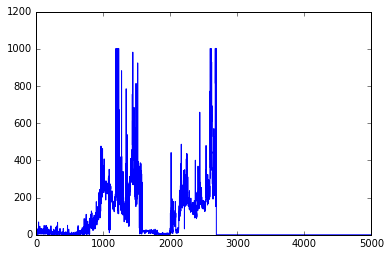

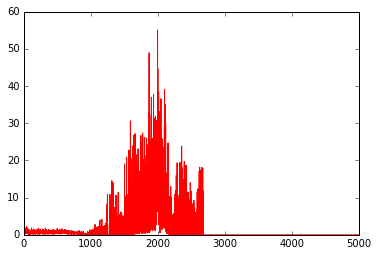

In [9]:
# print statistics  
print "max score:{} at episode:{}".format(max_reward,max_ep)
plt.plot(episode_rewards, lw=1)
plt.show()
plt.plot(loss, lw=1, c='r')
plt.show()

In [10]:
# for testing
episode_rewards_test = np.zeros(100)

for i_episode in xrange(100):

    state = env.reset()
    # init state
    state = np.array(state)
    for _ in xrange(AGENT_HISTORY_LENGTH):
        state_history.append(state)
    state = np.array(state_history)
    state = state.flatten()


    for t in itertools.count():
        # action

        q_values = train_model.predict(np.array([state]))[0]
        action = np.argmax(q_values)

        next_state, reward, done, info = env.step(action)
        
        # set the negative reward when the game end  
        if done == True :
            reward = -5

        # clip reward [-5,1]
        reward = max(-5, min(1, reward))
        
        # append next state
        next_state = np.array(next_state)
        state_history.append(next_state)
        next_state = np.array(state_history)
        next_state = next_state.flatten()
        
        # Save transition to replay memory
        replay_memory.append(Transition(state, action, reward, next_state, done))   
        
        # Update statistics
        episode_rewards_test[i_episode] += reward   

        # check if terminated
        if done or t > LIMIT_MAX_SCORE :
            break
        else:
            state = next_state
            
   
    
    ####### EPISODE END

    
    # print statistics    
    print 'Ep:%i\treward:%i' % (i_episode,episode_rewards_test[i_episode])
    
# print statistics   
print np.mean(episode_rewards_test)




Ep:0	reward:1002
Ep:1	reward:1002
Ep:2	reward:1002
Ep:3	reward:1002
Ep:4	reward:1002
Ep:5	reward:1002
Ep:6	reward:1002
Ep:7	reward:1002
Ep:8	reward:1002
Ep:9	reward:1002
Ep:10	reward:1002
Ep:11	reward:1002
Ep:12	reward:1002
Ep:13	reward:1002
Ep:14	reward:1002
Ep:15	reward:1002
Ep:16	reward:1002
Ep:17	reward:1002
Ep:18	reward:1002
Ep:19	reward:1002
Ep:20	reward:1002
Ep:21	reward:1002
Ep:22	reward:1002
Ep:23	reward:1002
Ep:24	reward:1002
Ep:25	reward:1002
Ep:26	reward:1002
Ep:27	reward:1002
Ep:28	reward:1002
Ep:29	reward:1002
Ep:30	reward:1002
Ep:31	reward:1002
Ep:32	reward:1002
Ep:33	reward:1002
Ep:34	reward:1002
Ep:35	reward:1002
Ep:36	reward:1002
Ep:37	reward:1002
Ep:38	reward:1002
Ep:39	reward:1002
Ep:40	reward:1002
Ep:41	reward:1002
Ep:42	reward:1002
Ep:43	reward:1002
Ep:44	reward:1002
Ep:45	reward:1002
Ep:46	reward:1002
Ep:47	reward:1002
Ep:48	reward:1002
Ep:49	reward:1002
Ep:50	reward:1002
Ep:51	reward:1002
Ep:52	reward:1002
Ep:53	reward:1002
Ep:54	reward:1002
Ep:55	reward:1002
Ep